In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

import tqdm
import matplotlib.pyplot as plt

/home/sidd_s/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image

In [3]:
class driving_dataset(Dataset):
    def __init__(self, imgs_path_lst, labels_path_lst, clusters_path_lst, lweaks_path_lst, data_transforms = None):
        self.imgs_path_lst = imgs_path_lst
        self.labels_path_lst = labels_path_lst
        self.clusters_path_lst = clusters_path_lst
        self.lweaks_path_lst = lweaks_path_lst
        
        if data_transforms:
            self.data_transforms = data_transforms
        
        self.imgs = []
        for path in self.imgs_path_lst:
            img = torch.tensor(np.array(Image.open(path)))
            self.imgs.append(img)
        print('Loaded', len(self.imgs), 'Images')
        
        self.labels = []
        for path in self.labels_path_lst:
            # label = torch.tensor(np.array(Image.open(path))).unsqueeze(0) # one channel # (C, H , W) here C = 1
            label = torch.tensor(np.array(Image.open(path)))
            self.labels.append(label) 
        print('Loaded', len(self.labels), 'Labels')
        
        self.lweaks = []
        for path in self.lweaks_path_lst:
            lweak = torch.tensor(np.array(Image.open(path))).unsqueeze(0) # one channel # (C, H , W) here C = 1
            self.lweaks.append(lweak)
        print('Loaded', len(self.lweaks), 'Lweaks')
        
        self.clusters = []
        for path in self.clusters_path_lst:
            cluster = torch.tensor(np.array(Image.open(path).convert('L'))).unsqueeze(0) # one channel # (C, H , W) here C = 1
            self.clusters.append(cluster) 
        print('Loaded', len(self.clusters), 'Clusters')
        
        self.ref_imgs = []
        for path in self.imgs_path_lst:
            ref_img = torch.tensor(np.array(Image.open(path.replace('val/night/GOPR0356','val_ref/day/GOPR0356_ref').replace('_rgb_anon.png','_ref_rgb_anon.png'))))
            self.ref_imgs.append(ref_img)
        print('Loaded', len(self.ref_imgs), 'Reference_Images')
        
        
    def __len__(self):
        assert len(self.imgs) == len(self.labels) == len(self.lweaks) == len(self.clusters)
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        cluster = self.clusters[idx]
        lweak = self.lweaks[idx]
        ref_img = self.ref_imgs[idx]
        
        name = self.imgs_path_lst[idx] 

        img, label, cluster, lweak, ref_img = self.data_transforms(img, label, cluster, lweak, ref_img)
        
        return {'img': img, 'label': label, 'cluster': cluster, 'lweak': lweak, 'ref_img': ref_img, 'name': name}

In [4]:
def data_transforms(img, label, cluster, lweak, ref_img):
        
        ## resizing similar to cluster make up 1 / 4th of original here...(270, 480)
        # img = F.interpolate(img.unsqueeze(0).float().permute(0,3,1,2), scale_factor=1/4, mode='nearest').squeeze(0) / 255.
        # label = F.interpolate(label.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)
        # cluster = F.interpolate(cluster.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)
        # lweak = F.interpolate(lweak.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)
        
        ## resizing similar to prior trained (256 , 512)
        img = F.interpolate(img.unsqueeze(0).float().permute(0,3,1,2), (256, 512), mode='nearest').squeeze(0) / 255.
        # label = F.interpolate(label.unsqueeze(0).float(), (256, 512), mode='nearest').squeeze(0)
        label = F.interpolate(label.unsqueeze(0).float().permute(0,3,1,2), (256, 512), mode='nearest').squeeze(0) / 255.
        cluster = F.interpolate(cluster.unsqueeze(0).float(), (256, 512), mode='nearest').squeeze(0)
        lweak = F.interpolate(lweak.unsqueeze(0).float(), (256, 512), mode='nearest').squeeze(0)
        ref_img = F.interpolate(ref_img.unsqueeze(0).float().permute(0,3,1,2), (256, 512), mode='nearest').squeeze(0) / 255.
        
        ## can tweak between the two, to see which one resolution is more apt
        return img, label, cluster, lweak, ref_img

In [5]:
imgs_paths_lst = glob.glob('/home/sidd_s/scratch/dataset/dark_zurich_val/rgb_anon/val/night/GOPR0356/*.png')
imgs_paths_lst.sort()
# labels_paths_lst = glob.glob('/home/sidd_s/scratch/dataset/dark_zurich_val/gt/val/night/GOPR0356/*_gt_labelTrainIds.png')
labels_paths_lst = glob.glob('/home/sidd_s/scratch/dataset/dark_zurich_val/gt/val/night/GOPR0356/*_gt_labelColor.png')
labels_paths_lst.sort()
clusters_paths_lst = glob.glob('/home/sidd_s/scratch/dataset/dark_zurich_val/clusters/*_ref_rgb_anon.png')
clusters_paths_lst.sort()
lweaks_paths_lst = glob.glob('/home/sidd_s/scratch/dataset/dark_zurich_val/pred/dannet_PSPNet_val/*_rgb_anon.png')
lweaks_paths_lst.sort()

In [6]:
device = torch.device('cuda:1')

In [7]:
n_clusters = n_labels =  19
dataset = driving_dataset(imgs_paths_lst, labels_paths_lst, clusters_paths_lst, lweaks_paths_lst,data_transforms)

# Create random patch-sampling dataloader
batch_size = 1
sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=sampler)
print('Created dataset')

Loaded 50 Images
Loaded 50 Labels
Loaded 50 Lweaks
Loaded 50 Clusters
Loaded 50 Reference_Images
Created dataset


In [8]:
def train_label_img_to_color(img): 
    label_to_color = {
        0: [128, 64,128],
        1: [244, 35,232],
        2: [ 70, 70, 70],
        3: [102,102,156],
        4: [190,153,153],
        5: [153,153,153],
        6: [250,170, 30],
        7: [220,220,  0],
        8: [107,142, 35],
        9: [152,251,152],
        10: [ 70,130,180],
        11: [220, 20, 60],
        12: [255,  0,  0],
        13: [  0,  0,142],
        14: [  0,  0, 70],
        15: [  0, 60,100],
        16: [  0, 80,100],
        17: [  0,  0,230],
        18: [119, 11, 32],
        19 : [0,  0, 0] 
        } 
    img_height, img_width = img.shape 
    img_color = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    for row in range(img_height):
        for col in range(img_width):
            label = img[row][col] 
            img_color[row, col] = np.array(label_to_color[label])  
    return img_color

In [9]:
# Sample random batch
for batch in dataloader:
    img = batch['img']
    label = batch['label']
    cluster = batch['cluster']
    lweak = batch['lweak']
    ref_img = batch['ref_img']
    
    name = batch['name']
    break 

print(name)

['/home/sidd_s/scratch/dataset/dark_zurich_val/rgb_anon/val/night/GOPR0356/GOPR0356_frame_000418_rgb_anon.png']


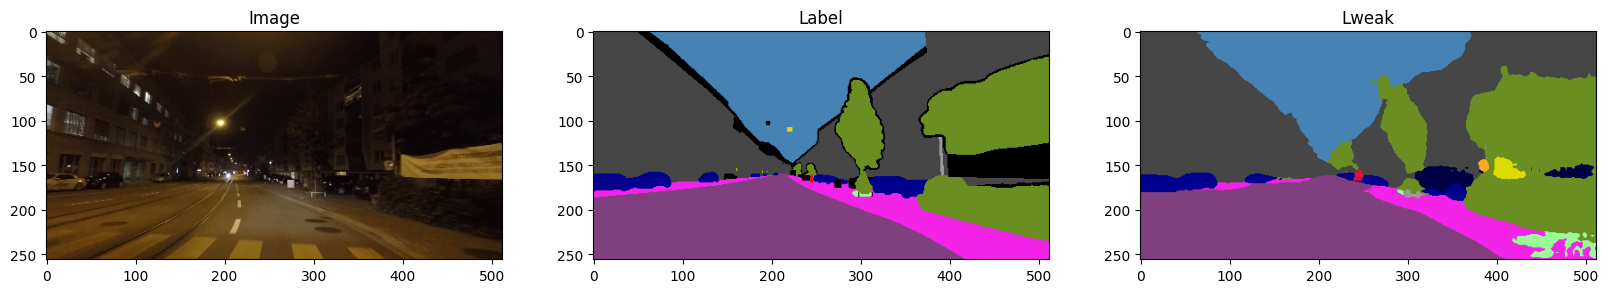

In [10]:
# Visualize
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(img.squeeze(0).numpy().transpose([1,2,0]))
ax[0].set_title('Image')
ax[1].imshow(label.squeeze(0).numpy().transpose([1,2,0]))
ax[1].set_title('Label')
# ax[2].imshow(ref_img.squeeze(0).numpy().transpose([1,2,0]))
# ax[2].set_title('Ref_Image')
ax[2].imshow(train_label_img_to_color(lweak.squeeze().numpy()))
ax[2].set_title('Lweak')
plt.show()

## Load Diffusion model --- taken from eval_sample.py of multinomial diffusion

In [287]:
from multinomial_diffusion.segmentation_diffusion.model import get_model
import argparse
import pickle 
import torch
from multinomial_diffusion.segmentation_diffusion.datasets.data import get_data, get_data_id, add_data_args, get_plot_transform
import os
from tqdm import tqdm
import torchvision
import imageio
from multinomial_diffusion.segmentation_diffusion.diffusion_utils import diffusion_multinomial
import math 
from tqdm import tqdm

In [288]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='/home/sidd_s/scratch/multinomial_diffusion_logpath/log_latest/flow/cityscapes_fine_train_v_large/multinomial_diffusion/multistep/2023-03-17_18-33-40')
parser.add_argument('--samples', type=int, default=5)
parser.add_argument('--nrow', type=int, default=1)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--double', type=eval, default=False)
parser.add_argument('--device', type=str, default='cuda:1')
eval_args = parser.parse_args("")

In [289]:
eval_args

Namespace(model='/home/sidd_s/scratch/multinomial_diffusion_logpath/log_latest/flow/cityscapes_fine_train_v_large/multinomial_diffusion/multistep/2023-03-17_18-33-40', samples=5, nrow=1, seed=0, double=False, device='cuda:1')

In [290]:
path_args = '{}/args.pickle'.format(eval_args.model)
path_check = '{}/check/checkpoint.pt'.format(eval_args.model)

torch.manual_seed(eval_args.seed)

In [291]:
###############
## Load args ##
###############

with open(path_args, 'rb') as f:
    diffusion_args = pickle.load(f)

In [292]:
data_shape = (1,256,512)

In [293]:
###################
## Specify model ##
###################

diffusion_model = get_model(diffusion_args, data_shape=data_shape)
if diffusion_args.parallel == 'dp':
    diffusion_model = DataParallelDistribution(diffusion_model)

if torch.cuda.is_available():
    checkpoint = torch.load(path_check)
else:
    checkpoint = torch.load(path_check, map_location='cpu')
diffusion_model.load_state_dict(checkpoint['model'])

if torch.cuda.is_available():
    diffusion_model = diffusion_model.to(device)

print('Loaded weights for model at {}/{} epochs'.format(checkpoint['current_epoch'], diffusion_args.epochs))

Loaded weights for model at 500/500 epochs


In [195]:
## run the below cells for getting lweak one hot label
# lweak_onehot.shape
lweak_onehot_stack = torch.stack([lweak_onehot, lweak_onehot, lweak_onehot, lweak_onehot, lweak_onehot]).to(device).permute(0, 2, 1, 3, 4)
lweak_onehot_stack.shape

torch.Size([5, 20, 1, 256, 512])

In [216]:
# lweak.shape # torch.Size([19, 256, 512])
lweak = lweak.unsqueeze(dim=0) 
background = torch.zeros(1,1,256,512)
lweak = torch.cat((lweak, background), dim = 1) 
lweak.shape # torch.Size([1, 20, 256, 512])

torch.Size([1, 20, 256, 512])

In [217]:
lweak_stack = torch.stack([lweak, lweak, lweak, lweak, lweak]).to(device).permute(0, 2, 1, 3, 4)
lweak_stack.shape

torch.Size([5, 20, 1, 256, 512])

In [367]:
def index_to_log_onehot(x, num_classes):
    assert x.max().item() < num_classes, \
        f'Error: {x.max().item()} >= {num_classes}'
    x_onehot = F.one_hot(x, num_classes)

    permute_order = (0, -1) + tuple(range(1, len(x.size())))

    x_onehot = x_onehot.permute(permute_order)

    log_x = torch.log(x_onehot.float().clamp(min=1e-30))

    return log_x

In [364]:
def log_sample_categorical(logits):
        uniform = torch.rand_like(logits)
        gumbel_noise = -torch.log(-torch.log(uniform + 1e-30) + 1e-30)
        # sample = (gumbel_noise + logits).argmax(dim=1)
        sample = F.softmax(logits, dim=1).argmax(dim=1)
        # log_sample = index_to_log_onehot(sample, num_classes=20)
        log_sample = logits
        return log_sample

In [368]:
def p_sample(log_x, t):
        model_log_prob = diffusion_model.p_pred(log_x=log_x, t=t)
        out = log_sample_categorical(model_log_prob)
        return out

In [369]:
def log_onehot_to_index(log_x):
    return log_x.argmax(1)

In [375]:
def sample_chain(num_samples):
        b = num_samples
        # uniform_logits = torch.zeros(
        #     (b, diffusion_model.num_classes) + diffusion_model.shape, device=device)
        # print(uniform_logits.shape) # torch.Size([5, 20, 1, 256, 512])
        # print(uniform_logits.unique())
        ## not giving uniform_logits but starting from lweak label from dannet model
        
        steps = diffusion_model.num_timesteps
        # steps = 1000
            
        # zs = torch.zeros((diffusion_model.num_timesteps, b) + diffusion_model.shape).long()
        zs = torch.zeros((steps, b) + diffusion_model.shape).long()

        # log_z = diffusion_model.log_sample_categorical(uniform_logits)
        # log_z = diffusion_model.log_sample_categorical(lweak_onehot_stack)
        log_z = log_sample_categorical(lweak_stack)
        
        # for i in reversed(range(0, diffusion_model.num_timesteps)):
        for i in reversed(range(0, steps)):
            print(f'Chain timestep {i:4d}', end='\r')
            t = torch.full((b,), i, device=device, dtype=torch.long)
            log_z = p_sample(log_z, t)

            zs[i] = log_onehot_to_index(log_z)
        print()
        return zs

In [376]:
############
## Sample ##
############    
plot_transform = get_plot_transform(diffusion_args)

def batch_samples_to_grid(batch):
    if len(batch.size()) == 3:
        batch = batch.unsqueeze(1)

    batch = plot_transform(batch).to(torch.uint8)

    grid = torchvision.utils.make_grid(
        batch, nrow=5, padding=2, normalize=False)

    grid = grid.permute(1, 2, 0)
    return grid

# path_samples = '{}/samples/sample_ep{}_s{}.png'.format(eval_args.model, checkpoint['current_epoch'], eval_args.seed)
path_samples = '{}/samples/sample_ep{}_s{}.png'.format('experiments', checkpoint['current_epoch'], eval_args.seed)
if not os.path.exists(os.path.dirname(path_samples)):
    os.makedirs(os.path.dirname(path_samples))

path_data_samples = '{}/samples/data.png'.format(eval_args.model,
                                                 checkpoint[
                                                     'current_epoch'],
                                                 eval_args.seed)
chain_samples = eval_args.samples
with torch.no_grad():
    samples_chain = sample_chain(chain_samples)

Chain timestep    0


In [377]:
samples_chain.shape

torch.Size([4000, 5, 1, 256, 512])

In [378]:
images = []
for samples_i in tqdm(samples_chain):
    grid = batch_samples_to_grid(samples_i)
    images.append(grid)

images = list(reversed(images))

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:11<00:00, 353.50it/s]


In [379]:
# imageio.imsave(path_samples, images[0]) # why why with noise why noise????>>>>>> Now, No noise it was the effect of gumbel noise on one hot vector

In [380]:
# len(images) # 500 

In [381]:
def chain_linspace(chain, num_steps=50, repeat_last=10):
    out = []
    for i in np.linspace(0, len(chain)-1, num_steps):
        idx = int(i)
        if idx >= len(chain):
            print('index too big')
            idx = idx - 1
        out.append(chain[idx])

    # So that the animation stalls at the final output.
    for i in range(repeat_last):
        out.append(chain[-1])
    return out


images = chain_linspace(images)
imageio.mimsave(path_samples[:-4] + '_chain.gif', images)
imageio.imsave(path_samples, images[-1])

## Run Inference

#### lweak probability distrubutions --- from DANNet 
#### z with its probability distribution from DANNet 

In [197]:
from DANNet.network import *
from DANNet.dataset.zurich_night_dataset import zurich_night_DataSet
from DANNet.configs.test_config import get_arguments
import sys
sys.argv = ['']
from torch.utils import data
import os
import torchvision.transforms as standard_transforms

In [198]:
args = get_arguments()
args

Namespace(model='PSPNet', data_dir='/home/sidd_s/scratch/dataset/dark_zurich_val/rgb_anon/val', data_list='/home/sidd_s/diffusion_priors/segmentation/DANNet/dataset/lists/zurich_val.txt', ignore_label=255, num_classes=19, restore_from='/home/sidd_s/scratch/saved_models/DANNet/dannet_psp.pth', restore_from_light='/home/sidd_s/scratch/saved_models/DANNet/dannet_psp_light.pth', set='train', save='/home/sidd_s/scratch/results/Dannet_dark_zurich', std=0.16)

In [199]:
if not os.path.exists(args.save):
    os.makedirs(args.save)

if args.model == 'PSPNet':
    model = PSPNet(num_classes=args.num_classes)
if args.model == 'DeepLab':
    model = Deeplab(num_classes=args.num_classes)
if args.model == 'RefineNet':
    model = RefineNet(num_classes=args.num_classes, imagenet=False)

saved_state_dict = torch.load(args.restore_from)
model_dict = model.state_dict()
saved_state_dict = {k: v for k, v in saved_state_dict.items() if k in model_dict}
model_dict.update(saved_state_dict)
model.load_state_dict(saved_state_dict)

lightnet = LightNet()
saved_state_dict = torch.load(args.restore_from_light)
model_dict = lightnet.state_dict()
saved_state_dict = {k: v for k, v in saved_state_dict.items() if k in model_dict}
model_dict.update(saved_state_dict)
lightnet.load_state_dict(saved_state_dict)

model = model.to(device)
lightnet = lightnet.to(device)
model.eval()
lightnet.eval()

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Reflect

In [200]:
weights = torch.log(torch.FloatTensor(
        [0.36869696, 0.06084986, 0.22824049, 0.00655399, 0.00877272, 0.01227341, 0.00207795, 0.0055127, 0.15928651,
         0.01157818, 0.04018982, 0.01218957, 0.00135122, 0.06994545, 0.00267456, 0.00235192, 0.00232904, 0.00098658,
         0.00413907])).to(device)
weights = (torch.mean(weights) - weights) / torch.std(weights) * args.std + 1.0

In [201]:
interp = nn.Upsample(size=(256, 512), mode='bilinear', align_corners=True) # for prior shape matching 
# interp = nn.Upsample(size=(1080, 1920), mode='bilinear', align_corners=True) # for dark zurich dataset 

In [202]:
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
val_input_transform = standard_transforms.Compose([
            standard_transforms.Resize((540, 960)),
            standard_transforms.ToTensor(),
            standard_transforms.Normalize(*mean_std)
        ]) 

In [203]:
lweak_img = Image.open(name[0]).convert('RGB')
lweak_img = val_input_transform(lweak_img)
lweak_img = lweak_img.to(device).unsqueeze(0) # batch 1 for now

In [204]:
ref_name = name[0].replace('val/night/GOPR0356','val_ref/day/GOPR0356_ref').replace('_rgb_anon.png','_ref_rgb_anon.png')
# ref_img

In [205]:
ref_img = Image.open(ref_name).convert('RGB')
ref_img = val_input_transform(ref_img)
ref_img = ref_img.to(device).unsqueeze(0) # batch 1 for now

In [133]:
# lweak_img.shape
# ref_img.shape

In [206]:
def prediction_dannet(img):
    with torch.no_grad():
        r = lightnet(img)
        enhancement = img + r
        if args.model == 'RefineNet':
            output2 = model(enhancement)
        else:
            _, output2 = model(enhancement)

    weights_prob = weights.expand(output2.size()[0], output2.size()[3], output2.size()[2], 19)
    weights_prob = weights_prob.transpose(1, 3)
    output2 = output2 * weights_prob
    output = interp(output2).cpu().data[0].numpy()
    return output 

In [207]:
lweak = prediction_dannet(lweak_img)
z = prediction_dannet(ref_img)

/home/sidd_s/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [208]:
lweak.shape

(19, 256, 512)

In [209]:
z.shape

(19, 256, 512)

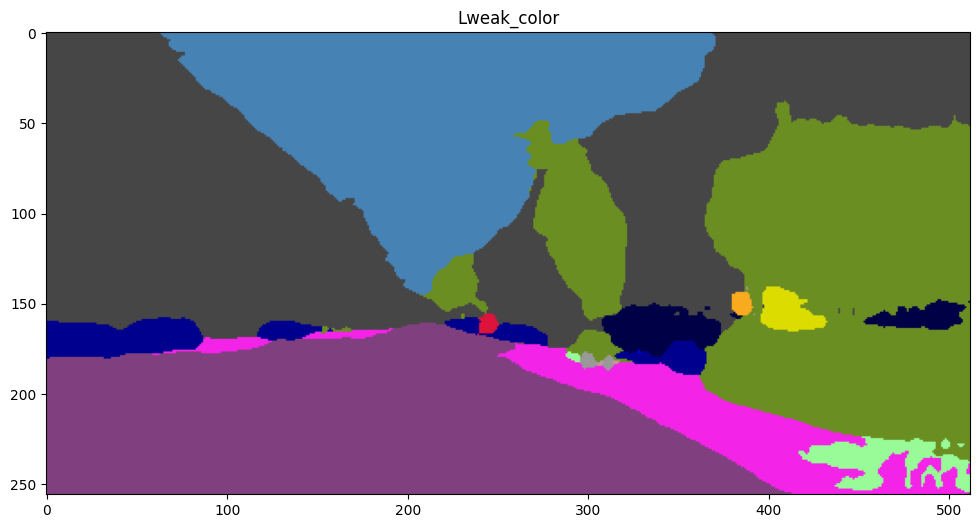

In [211]:
# Visualize
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.imshow(train_label_img_to_color(np.argmax(lweak, axis=0)))
ax.set_title('Lweak_color')
# ax[1].imshow(train_label_img_to_color(np.argmax(z, axis=0)))
# ax[1].set_title('z_color')
plt.show()
# plt.savefig('Dannet_prediction.png')

#### Comparision between 1080x1920 probability distribution and 256x512 probability distribution

In [ ]:
# np.array(output).shape
# np.unique(output)
(unique, counts) = np.unique(output, return_counts=True)

In [ ]:
unique

In [ ]:
counts

In [ ]:
out_arr = np.array(output)
out_flat = out_arr.flatten()
out_lst = out_flat.tolist()

In [ ]:
counts/len(out_lst)

In [ ]:
# out_arr.shape
# out_flat.shape
# len(out_lst)

In [ ]:
plt.hist(out_lst, range=(0,20), bins=19)
plt.show()

##### 256x512 probability distribution

In [ ]:
# np.array(output).shape
# np.unique(output)
(unique, counts) = np.unique(output, return_counts=True)

In [ ]:
unique

In [ ]:
counts

In [ ]:
out_arr = np.array(output)
out_flat = out_arr.flatten()
out_lst = out_flat.tolist()

In [ ]:
counts/len(out_lst)

In [ ]:
plt.hist(out_lst, range=(0,20), bins=19)
plt.show()

In [ ]:
# output.save('%s/%s' % (args.save, name))
# output_col.save('%s/%s_color.png' % (args.save, name.split('.')[0]))

In [ ]:
# out_arr.shape
# lweak.shape

In [ ]:
# out_color = train_label_img_to_color(output)

In [ ]:
# out_color.shape # torch.Size([256, 512, 3])

In [ ]:
# Visualize
idx = idx = np.random.randint(0, img.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
# ax[0].imshow(lweak.numpy()[0,0,:,:])
# ax[0].set_title('Lweak_saved')
ax[0].imshow(train_label_img_to_color(lweak).numpy() / 255.)
ax[0].set_title('Lweak')
ax[1].imshow(train_label_img_to_color(torch.tensor(output_lb)).numpy() / 255.)
ax[1].set_title('Lweak_from_probability_distribution')
plt.show()

In [ ]:
img.shape

In [ ]:
ref_img.shape

In [ ]:
lweak.shape

In [ ]:
oc_clusters.shape

In [ ]:
output.shape

In [ ]:
device

### Model inference training

In [212]:
class MILoss(nn.Module):
    def __init__(self, win_size=15):
        super(MILoss, self).__init__()
        
        self.pooling = nn.Sequential(
            nn.AvgPool2d(win_size, 1, (win_size-1)//2, count_include_pad=False),
            #nn.AvgPool2d(win_size, 1),
        )
    
    def forward(self, labels, clusters, n_clusters):
        labels = F.normalize(labels + 1e-9, p=1, dim=1)
        clusters = F.normalize(clusters + 1e-9, p=1, dim=1)
        
        plc = []
        for i in range(n_clusters):
            x = labels * clusters[:,[i],:,:]
            x = self.pooling(x)
            plc.append(x)
        plc = torch.stack(plc, dim=2)
        
        #plc = F.normalize(plc + 1e-9, p=1, dim=(1,2)) 
        
        pl = torch.sum(plc, dim=2)
        pc = torch.sum(plc, dim=1)
        hl = -torch.sum(pl * torch.log(pl), dim=1)
        hc = -torch.sum(pc * torch.log(pc), dim=1).detach()
        
        pl_c = plc / pc.unsqueeze(1)
        
        hl_c = -torch.sum(pc * torch.sum(pl_c * torch.log(pl_c), dim=1), dim=1)
        
        mi = hl - hl_c
               
        return mi / (hc+hl)

In [213]:
class KLLoss(nn.Module):
    def __init__(self, win_size=15):
        super(KLLoss, self).__init__()
        
        self.pooling = nn.Sequential(
            nn.AvgPool2d(win_size, 1, (win_size-1)//2, count_include_pad=False),
            #nn.AvgPool2d(win_size, win_size, 0),
        )
    
    def forward(self, labels, lweaks):
        labels_pooled = self.pooling(labels)
        lweaks_pooled = lweaks #self.pooling(lweaks)
        
        #return torch.sum(lweaks_pooled * torch.log(labels_pooled), dim=1).mean()
        return F.kl_div(torch.log(labels_pooled), lweaks_pooled)


In [214]:
diffusion_args.diffusion_steps

4000

In [215]:
lweak = torch.tensor(lweak)
z = torch.tensor(z)

In [58]:
lweak_onehot = F.one_hot(lweak.argmax(dim=0), num_classes=19)
lweak_onehot = lweak_onehot.permute(2,0,1).unsqueeze(dim=0)
z_prob = F.softmax(z, dim=0).unsqueeze(dim=0)
# lweak_prob = F.softmax(lweak, dim=0)

In [59]:
## increasing the channel number of lweak_onehot and z_prob to 20 for taking background into consideration

background = torch.zeros(1,1,256,512)
lweak_onehot = torch.cat((lweak_onehot, background), dim = 1) 
z_prob = torch.cat((z_prob, background), dim=1)

In [61]:
# lweak_onehot.shape # torch.Size([1, 20, 256, 512])
# z_prob.shape # torch.Size([1, 20, 256, 512]) 

In [301]:
class Model(nn.Module):
    def __init__(self, prior, size=(256,512)):
        super(Model, self).__init__()
        self.size = size
        self.prior = prior # Infer the one-hot segmentation map 
        # Initialize with the prior + added uncertainty ### is uncertainty neccessary here>?? in multinomial case??
        # self.seg_map = nn.Parameter(F.normalize(self.prior.clone() + 1e-6, p=1, dim=1)) ## can try in 2nd attemt!!
        self.seg_map = nn.Parameter(self.prior.clone())  
        self.seg_map.requires_grad = True
        
    def encode(self):
        return self.seg_map
    
    def __normal_cdf(self, x, mu, sigma):
            return 0.5 * (1 + torch.erf((x-mu)/(sigma*math.sqrt(2))))
        
    def encode_prob(self, sigma):
        # Encode learned map into probabilities
        x = self.__normal_cdf(1.5, self.seg_map, sigma) - self.__normal_cdf(0.5, self.seg_map, sigma)
        # Normalize
        x = F.normalize(x + 1e-9, p=1, dim=1)
        return x
    
steps = 500
    
model = Model(prior = lweak_onehot).to(device) ## init prior as being lweak one hot label for fast inference 
model.train()
opt = torch.optim.Adam(model.parameters(), lr=0.01)#, betas=(0, 0.999))
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1, end_factor=0.0001, total_iters=steps)

batch_size = 1 # hard coding for now  

In [302]:
diffusion_args.device = torch.device('cuda:1')

In [303]:
###################
## Specify diffusion model ##
###################

diffusion_net = get_model(diffusion_args, data_shape=data_shape)
if diffusion_args.parallel == 'dp':
    diffusion_net = DataParallelDistribution(diffusion_net)

if torch.cuda.is_available():
    checkpoint = torch.load(path_check)
else:
    checkpoint = torch.load(path_check, map_location='cpu')
diffusion_net.load_state_dict(checkpoint['model'])

if torch.cuda.is_available():
    diffusion_net = diffusion_net.to(diffusion_args.device)

diffusion_net.train()
print('Loaded weights for model at {}/{} epochs'.format(checkpoint['current_epoch'], diffusion_args.epochs))

Loaded weights for model at 500/500 epochs


In [304]:
from multinomial_diffusion.segmentation_diffusion.diffusion_utils import diffusion_multinomial
import math 

In [97]:
## diffusion building up

In [305]:
num_classes = 20 # 19 + 1 (background)  
n_clusters = 20 # also increasing from 19 as concatenated an extra channel dimension of zeros in lweak_onehot and z_prob

  0%|                                                                                                                   | 0/500 [00:00<?, ?it/s, Loss=0.272]

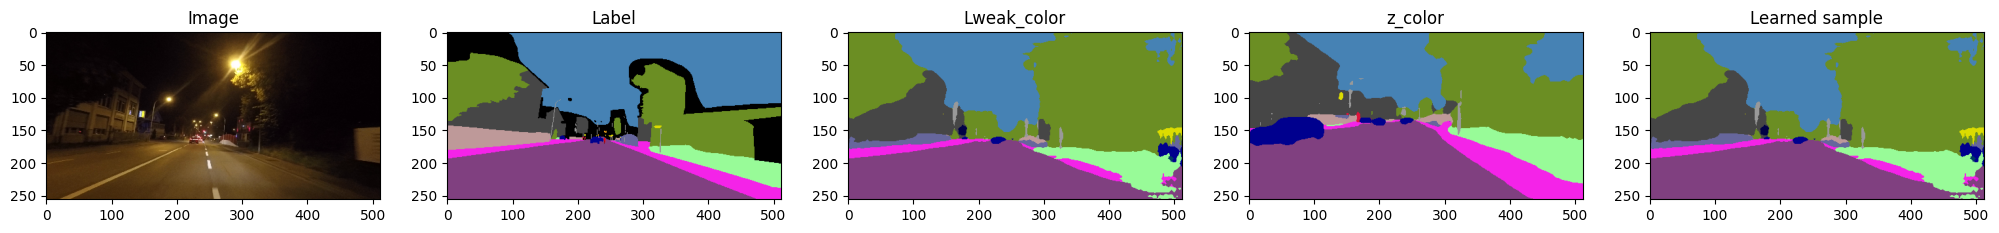

 20%|████████████████████▉                                                                                     | 99/500 [01:01<04:03,  1.65it/s, Loss=0.522]

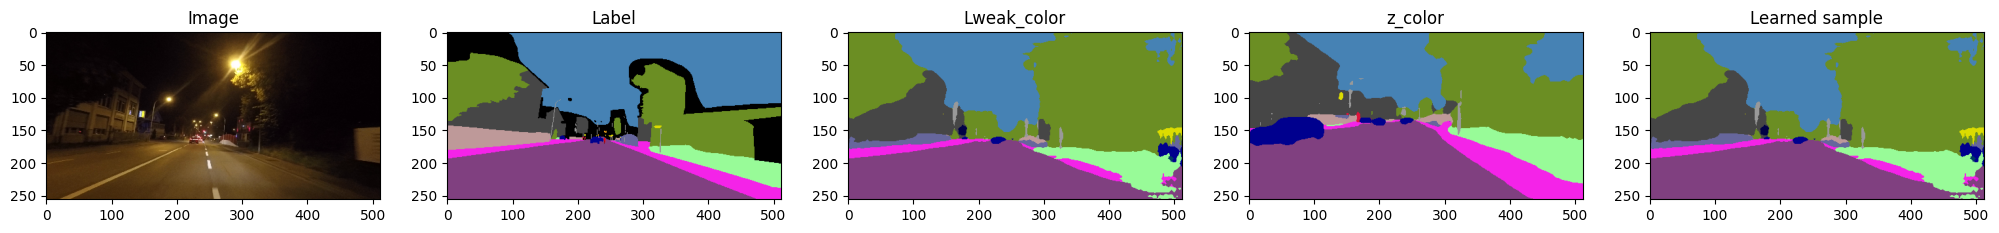

 40%|█████████████████████████████████████████▊                                                               | 199/500 [02:03<03:05,  1.62it/s, Loss=0.358]

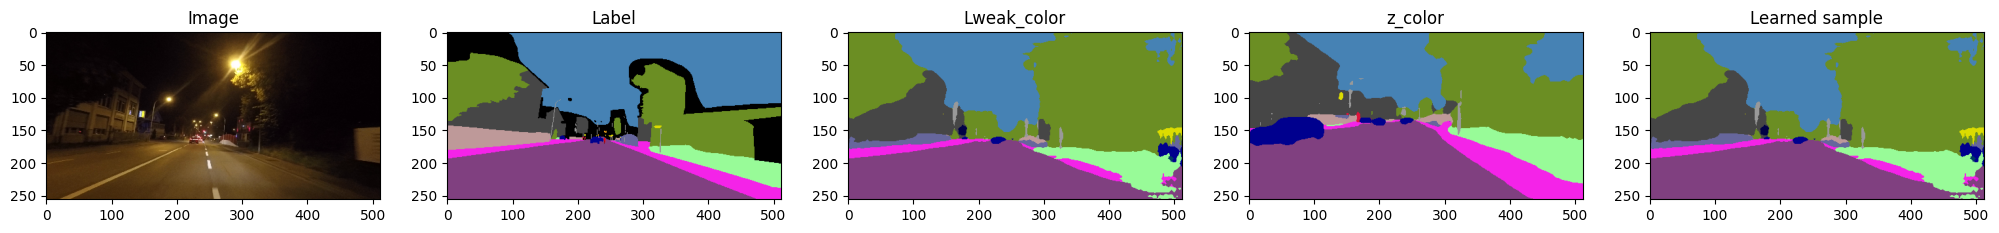

 60%|██████████████████████████████████████████████████████████████▊                                          | 299/500 [03:07<02:06,  1.59it/s, Loss=0.315]

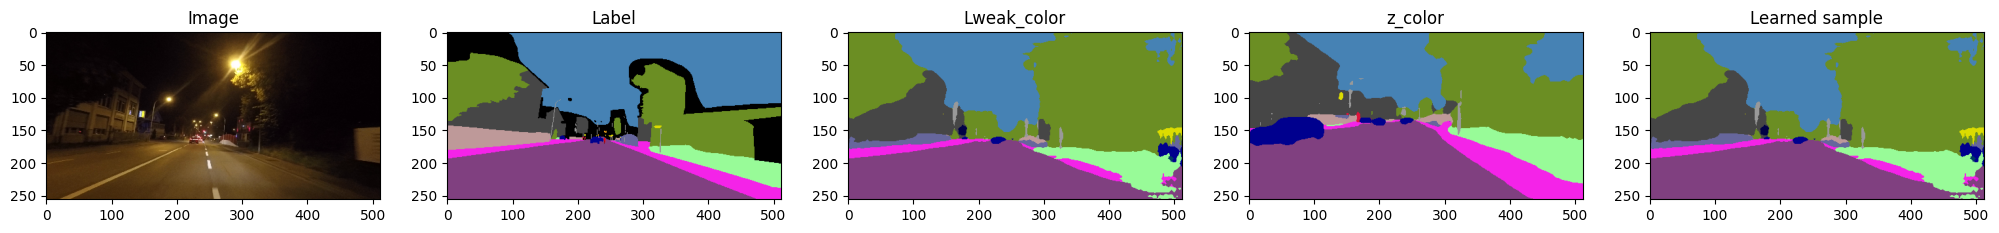

 80%|████████████████████████████████████████████████████████████████████████████████████▌                     | 399/500 [04:10<01:01,  1.64it/s, Loss=0.35]

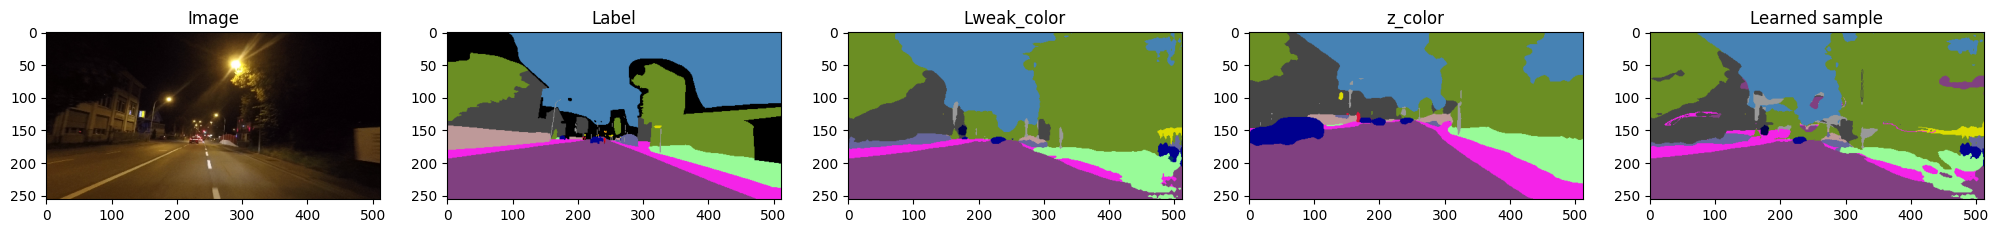

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:12<00:00,  1.64it/s, Loss=0.746]

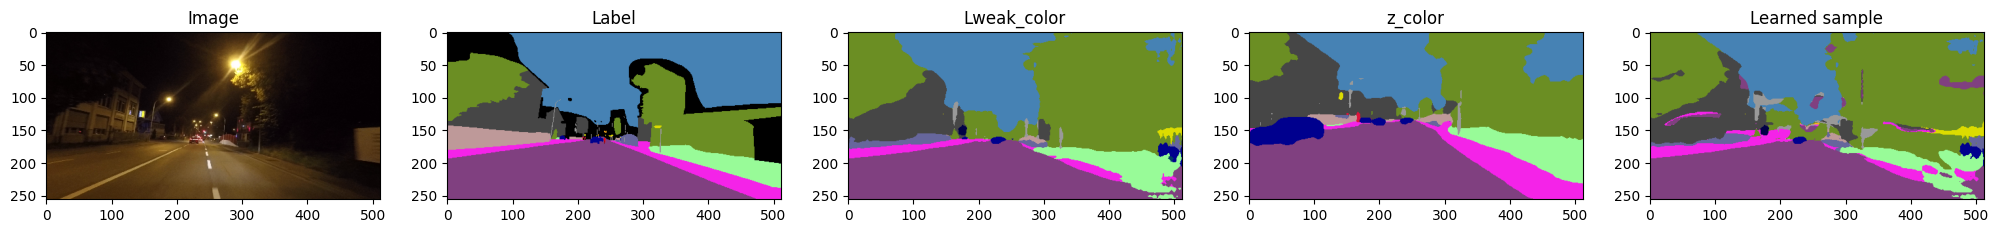

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:14<00:00,  1.59it/s, Loss=0.746]


In [307]:
bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
vis_every = 100
size_numel = 256*512

for i, _ in enumerate(bar):     
    
    # Diffusion pops in 
    ## select t with its pt 
    t,pt = diffusion_net.sample_time(b=1, device=device, method = 'importance') 
    ## predict the start vector in categorical based diffusion
    seg_map = model.encode() 
    log_x_start = torch.log(seg_map.float().clamp(min=1e-30))
    
    kl = diffusion_net.compute_Lt(log_x_start.to(diffusion_args.device), diffusion_net.q_sample(log_x_start=log_x_start.to(diffusion_args.device), t=t), t)
    
    Lt2 = kl.pow(2)
    Lt2_prev = diffusion_net.Lt_history.gather(dim=0, index=t)
    new_Lt_history = (0.1 * Lt2 + 0.9 * Lt2_prev).detach()
    diffusion_net.Lt_history.scatter_(dim=0, index=t, src=new_Lt_history)
    diffusion_net.Lt_count.scatter_add_(dim=0, index=t, src=torch.ones_like(Lt2))

    kl_prior = diffusion_net.kl_prior(log_x_start)
    
    # Upweigh loss term of the kl
    vb_loss = kl/pt + kl_prior
    elbo_bpd = vb_loss.sum() / (math.log(2) * size_numel)
    
    # Compute MI 
    # Reduce MI window gradually
    k = steps-i
    if k > 4*steps//5:
        win_size = 31
    elif k > 3*steps//5:
        win_size = 25
    elif k > 2*steps//5:
        win_size = 17
    elif k > 1*steps//5:
        win_size = 11
    else:
        win_size = 7
    win_size = 31
    mi_loss = MILoss(win_size)
    
    # Reduce sigma gradually
    sigma = np.clip(0.2*(steps-i)/steps, 0.02, 1)
    loss_mi = mi_loss(model.encode_prob(sigma), z_prob.float().to(device), n_clusters).mean()  ## z_prob is the proba distribution of ref day image from dannet 
    
    KL_loss = KLLoss(31)
    loss_kl = KL_loss(model.encode_prob(sigma), lweak_onehot.float().to(device)).mean()  
    
    # Compute loss and backprop
    # loss = elbo_bpd - np.clip((steps-i)/steps, 0, 1)*loss_mi + np.clip((steps-i)/steps, 0, 1)*loss_kl
    # loss = - np.clip((steps-i)/steps, 0, 1)*loss_mi + np.clip((steps-i)/steps, 0, 1)*loss_kl
    loss = elbo_bpd - loss_mi + np.clip((steps-i)/steps, 0, 1)*loss_kl
    
    opt.zero_grad()
    loss.backward() 
    opt.step()
    scheduler.step()
    
    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []
        
    # Visualize sample 
    if (i+1) % vis_every == 0 or i == 0:
        fig, ax = plt.subplots(1, 5, figsize=(25,5))
        ax[0].imshow(img[0].cpu().numpy().transpose([1,2,0]))
        ax[0].set_title('Image')
        ax[1].imshow(label[0].cpu().numpy().transpose([1,2,0]))
        ax[1].set_title('Label')
        ax[2].imshow(train_label_img_to_color(np.argmax(lweak.numpy(), axis=0)))
        ax[2].set_title('Lweak_color')
        ax[3].imshow(train_label_img_to_color(np.argmax(z.numpy(), axis=0)))
        ax[3].set_title('z_color')
        ax[4].imshow(train_label_img_to_color(np.argmax(model.encode_prob(sigma)[0].detach().cpu().numpy(), axis = 0)))
        ax[4].set_title('Learned sample')
        plt.show()
        
    plt.imsave('learner_sample.png', train_label_img_to_color(np.argmax(model.encode_prob(sigma)[0].detach().cpu().numpy(), axis = 0)))